In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import os
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import scipy

In [3]:
print(tf.__version__)
print(tf.compat.v1.config.experimental.set_visible_devices)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

1.15.0
<function set_visible_devices at 0x7f7f89ebbc20>
Num GPUs Available:  1
Default GPU Device: /device:GPU:0


2022-07-21 19:50:05.942192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-21 19:50:06.197774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 19:50:06.198481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-07-21 19:50:06.200227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-07-21 19:50:06.202299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-07-21 19:50:06.205432: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import glob

In [6]:
train_dir = 'intel-image-classification/seg_train/seg_train'
test_dir = 'intel-image-classification/seg_test/seg_test'
pred_dir = 'intel-image-classification/seg_pred/seg_pred'


labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [7]:
trainGen = ImageDataGenerator(rescale = 1./255)
testGen = ImageDataGenerator(rescale = 1./255)

In [8]:
train = trainGen.flow_from_directory(train_dir,
                                        class_mode='categorical',
                                        target_size=(224,224),
                                        batch_size=32,
                                         classes = labels
                                    )

test = testGen.flow_from_directory(test_dir,
                                  class_mode='categorical',
                                  target_size=(224,224),
                                  batch_size=32,
                                   classes = labels
                                  )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
def view_random_image(dirname):
    class_names = train.class_names
    random_class = random.choice(class_names)
    dirname = train_dir
    random_image_folder = os.path.join(dirname,random_class)
    random_image = random.choice(os.listdir(random_image_folder))
    random_image_path = os.path.join(random_image_folder,random_image)
    image = mpimg.imread(random_image_path)
    plt.imshow(image)
    plt.title(f"Random Image of: {random_class}");


In [11]:
view_random_image(train_dir)

AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

In [8]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train = train.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
# test = test.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

# labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# MobileNet_v2

Get the mobilenet_v2 pretrained model and then add my dataset in the last layer and then train and save the model.

In [9]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Adam Optimizer (MobileNet)

In [10]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-07-21 19:50:27.887145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 19:50:27.887938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-07-21 19:50:27.887976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-07-21 19:50:27.887994: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-07-21 19:50:27.888010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-07-21 19:50:27.888025: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-07-21 19:50:32.549301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 19:50:32.550156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-07-21 19:50:32.550198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-07-21 19:50:32.550217: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-07-21 19:50:32.550234: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-07-21 19:50:32.550264: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-07-21 19:50:35.002730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-07-21 19:50:35.329616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


439/439 [==============================] - 47s 107ms/step - loss: 0.3423 - acc: 0.8777 - val_loss: 0.2651 - val_acc: 0.9080
Epoch 2/10
439/439 [==============================] - 19s 43ms/step - loss: 0.2291 - acc: 0.9161 - val_loss: 0.2589 - val_acc: 0.9097
Epoch 3/10
439/439 [==============================] - 19s 43ms/step - loss: 0.2023 - acc: 0.9250 - val_loss: 0.2508 - val_acc: 0.9080
Epoch 4/10
439/439 [==============================] - 19s 44ms/step - loss: 0.1859 - acc: 0.9307 - val_loss: 0.2567 - val_acc: 0.9028
Epoch 5/10
439/439 [==============================] - 20s 45ms/step - loss: 0.1718 - acc: 0.9357 - val_loss: 0.2546 - val_acc: 0.9132
Epoch 6/10
439/439 [==============================] - 19s 43ms/step - loss: 0.1648 - acc: 0.9388 - val_loss: 0.2495 - val_acc: 0.9167
Epoch 7/10
439/439 [==============================] - 18s 42ms/step - loss: 0.1542 - acc: 0.9417 - val_loss: 0.2678 - val_acc: 0.8924
Epoch 8/10
439/439 [==============================] - 18s 41ms/step - lo

In [12]:
model.evaluate(test)

94/94 [==============================] - 9s 96ms/step - loss: 0.2421 - acc: 0.9177


[0.24214227299423927, 0.9176667]

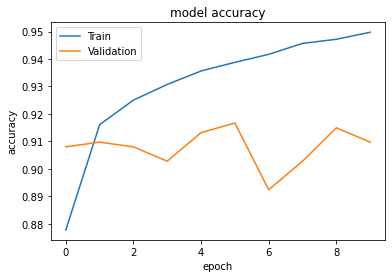

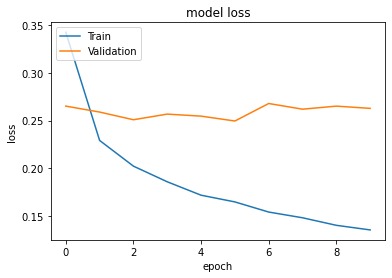

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_MN_Adam"
model.save(export_path)

export_path

'savedModels/Intel_MN_Adam'

In [15]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/Intel_MN_Adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94/94 [==============================] - 5s 52ms/step - loss: 0.2419 - acc: 0.9177


[0.2419258449722002, 0.9176667]

# SGD Optimizer (MobileNet)

In [16]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
439/439 [==============================] - 22s 49ms/step - loss: 0.4089 - acc: 0.8574 - val_loss: 0.2700 - val_acc: 0.9028
Epoch 2/10
439/439 [==============================] - 19s 43ms/step - loss: 0.2630 - acc: 0.9044 - val_loss: 0.2438 - val_acc: 0.9010
Epoch 3/10
439/439 [==============================] - 19s 44ms/step - loss: 0.2422 - acc: 0.9126 - val_loss: 0.2300 - val_acc: 0.9097
Epoch 4/10
439/439 [==============================] - 18s 42ms/step - loss: 0.2292 - acc: 0.9169 - val_loss: 0.2227 - val_acc: 0.9132
Epoch 5/10
439/439 [==============================] - 19s 44ms/step - loss: 0.2209 - acc: 0.9185 - val_loss: 0.2237 - val_acc: 0.9115
Epoch 6/10
439/439 [==============================] - 18s 42ms/step - loss: 0.2144 - acc: 0.9204 - val_loss: 0.2156 - val_acc: 0.9167
Epoch 7/10
439/439 [==============================] - 19s 43ms/step - loss: 0.2088 - acc: 0.9218 - val_loss: 0.2154 - val_acc: 0.9132
Epoch 8/10
439/439 [==============================] - 19s 44ms

In [18]:
model.evaluate(test)

94/94 [==============================] - 4s 43ms/step - loss: 0.2294 - acc: 0.9120


[0.22940892012829475, 0.912]

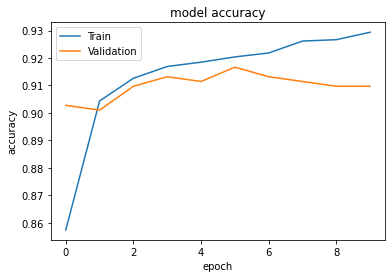

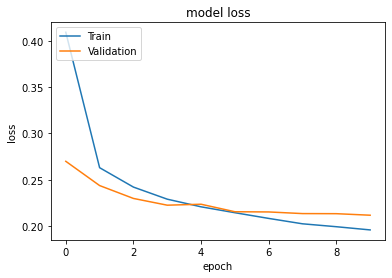

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_MN_Sgd"
model.save(export_path)

export_path

'savedModels/Intel_MN_Sgd'

In [21]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/Intel_MN_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

94/94 [==============================] - 5s 55ms/step - loss: 0.2294 - acc: 0.9120


[0.22940892012829475, 0.912]

# Newton Optimizer (MobileNet)

In [22]:
import newton_cg as es

In [23]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
439/439 [==============================] - 23s 52ms/step - loss: 1.4764 - acc: 0.4066 - val_loss: 1.1895 - val_acc: 0.5868
Epoch 2/10
439/439 [==============================] - 19s 44ms/step - loss: 0.9888 - acc: 0.7088 - val_loss: 0.8957 - val_acc: 0.7396
Epoch 3/10
439/439 [==============================] - 20s 45ms/step - loss: 0.7684 - acc: 0.8045 - val_loss: 0.7274 - val_acc: 0.8073
Epoch 4/10
439/439 [==============================] - 20s 45ms/step - loss: 0.6353 - acc: 0.8405 - val_loss: 0.6180 - val_acc: 0.8212
Epoch 5/10
439/439 [==============================] - 20s 44ms/step - loss: 0.5466 - acc: 0.8574 - val_loss: 0.5411 - val_acc: 0.8472
Epoch 6/10
439/439 [==============================] - 20s 46ms/step - loss: 0.4829 - acc: 0.8673 - val_loss: 0.4838 - val_acc: 0.8611
Epoch 7/10
439/439 [====================

In [25]:
model.evaluate(test)

94/94 [==============================] - 4s 47ms/step - loss: 0.3478 - acc: 0.8910


[0.3478238853685399, 0.891]

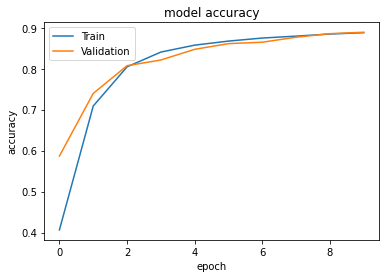

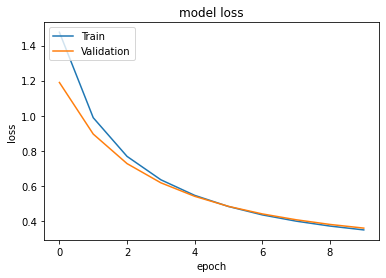

In [26]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_MN_newton"
model.save(export_path)

export_path

'savedModels/Intel_MN_newton'

In [73]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/Intel_MN_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer, 'MyOptimizer': newton_opt})

reloaded.evaluate(test)

ValueError: Unknown optimizer: EHNewtonOptimizer

# Testing on an image from the internet

In [56]:
import urllib.request
from tensorflow.keras.preprocessing import image


# url = "https://image.freepik.com/free-photo/front-view-nice-street-city_23-2148798644.jpg"
url = "https://media.istockphoto.com/photos/snowcapped-k2-peak-picture-id1288385045?b=1&k=20&m=1288385045&s=170667a&w=0&h=3M3ZRl1bxOGxcvmYZ-TOtuJ3idm0psm4c7GFba1TA5g="
urllib.request.urlretrieve(url, 'image.jpg')

# Load image and resize (doesn't keep aspect ratio)
img1 = image.load_img('image.jpg', target_size=(224, 224))
# Turn to array of shape (224, 224, 3)
img = image.img_to_array(img1)
# Expand array into (1, 224, 224, 3)
img = np.expand_dims(img, 0)

img = img /255

[[0.0000015  0.00000097 0.03524365 0.9647522  0.00000005 0.0000017 ]]
This image is a mountain


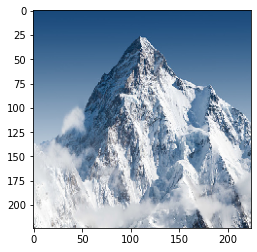

In [61]:
np.set_printoptions(suppress=True)
pred = reloaded.predict(img)
print (pred)

print ('This image is a', labels[np.argmax(pred)])
plt.imshow(img1)
plt.show()

If I need to get a percentage and probability for each class, I should add softmax on the output as the activation layer so as to get the probability of each class. So, get the saved model and add a layer with the softmax function and try again.

# ----------------------------------------------------------

# Inception_v3

In [28]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (Inception)

In [10]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-06-04 17:17:25.571134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 17:17:25.572342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-04 17:17:25.572410: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-04 17:17:25.572446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-04 17:17:25.572479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-04 17:17:25.572511: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-04 17:20:04.311310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 17:20:04.312551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-04 17:20:04.312619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-04 17:20:04.312655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-04 17:20:04.312687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-04 17:20:04.312718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-06-04 17:20:11.226722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-04 17:20:12.113918: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


439/439 [==============================] - 37s 84ms/step - loss: 0.3394 - acc: 0.8743 - val_loss: 0.2609 - val_acc: 0.8993
Epoch 2/10
439/439 [==============================] - 26s 60ms/step - loss: 0.2392 - acc: 0.9129 - val_loss: 0.2394 - val_acc: 0.9010
Epoch 3/10
439/439 [==============================] - 27s 62ms/step - loss: 0.2099 - acc: 0.9211 - val_loss: 0.2891 - val_acc: 0.8802
Epoch 4/10
439/439 [==============================] - 26s 60ms/step - loss: 0.1937 - acc: 0.9290 - val_loss: 0.2588 - val_acc: 0.9045
Epoch 5/10
439/439 [==============================] - 27s 61ms/step - loss: 0.1812 - acc: 0.9332 - val_loss: 0.2547 - val_acc: 0.8958
Epoch 6/10
439/439 [==============================] - 28s 63ms/step - loss: 0.1739 - acc: 0.9352 - val_loss: 0.2824 - val_acc: 0.8993
Epoch 7/10
439/439 [==============================] - 27s 61ms/step - loss: 0.1652 - acc: 0.9382 - val_loss: 0.2914 - val_acc: 0.8924
Epoch 8/10
439/439 [==============================] - 27s 61ms/step - los

In [12]:
model.evaluate(test)

94/94 [==============================] - 6s 62ms/step - loss: 0.2572 - acc: 0.9050


[0.2571768554997571, 0.905]

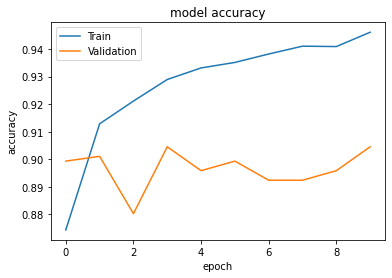

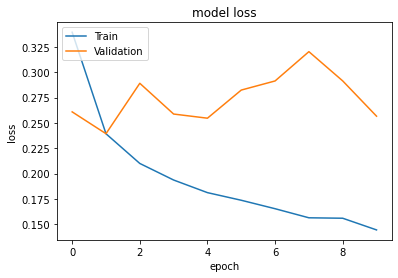

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_inception_adam"
model.save(export_path)

export_path

'savedModels/Intel_inception_adam'

In [15]:
export_path = "savedModels/Intel_inception_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94/94 [==============================] - 9s 97ms/step - loss: 0.2569 - acc: 0.9050


[0.25692372578889766, 0.905]

## SGD Optimizer (Inception)

In [11]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-06-06 15:01:41.979846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 15:01:41.981088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 15:01:41.981146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 15:01:41.981179: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 15:01:41.981209: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 15:01:41.981238: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-06 15:02:04.804182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 15:02:04.805566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 15:02:04.805636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 15:02:04.805673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 15:02:04.805706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 15:02:04.805737: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-06-06 15:02:16.844963: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 15:02:17.793136: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


439/439 [==============================] - 62s 142ms/step - loss: 0.4009 - acc: 0.8598 - val_loss: 0.3222 - val_acc: 0.8715
Epoch 2/10
439/439 [==============================] - 30s 69ms/step - loss: 0.2732 - acc: 0.9010 - val_loss: 0.2989 - val_acc: 0.8854
Epoch 3/10
439/439 [==============================] - 27s 62ms/step - loss: 0.2501 - acc: 0.9114 - val_loss: 0.2841 - val_acc: 0.8889
Epoch 4/10
439/439 [==============================] - 28s 64ms/step - loss: 0.2357 - acc: 0.9155 - val_loss: 0.2811 - val_acc: 0.8906
Epoch 5/10
439/439 [==============================] - 27s 62ms/step - loss: 0.2257 - acc: 0.9190 - val_loss: 0.2824 - val_acc: 0.8924
Epoch 6/10
439/439 [==============================] - 27s 63ms/step - loss: 0.2164 - acc: 0.9211 - val_loss: 0.2700 - val_acc: 0.8958
Epoch 7/10
439/439 [==============================] - 27s 61ms/step - loss: 0.2099 - acc: 0.9233 - val_loss: 0.2705 - val_acc: 0.9045
Epoch 8/10
439/439 [==============================] - 27s 62ms/step - lo

In [15]:
model.evaluate(test)

94/94 [==============================] - 6s 59ms/step - loss: 0.2362 - acc: 0.9117


[0.23620409510554152, 0.9116667]

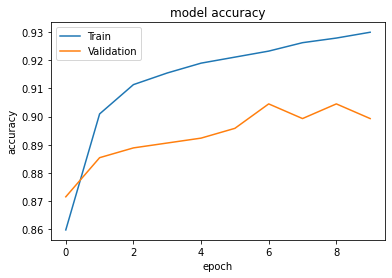

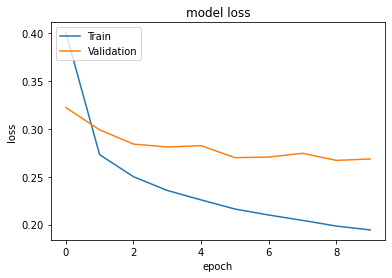

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_inception_Sgd"
model.save(export_path)

export_path

'savedModels/Intel_inception_Sgd'

In [18]:
export_path = "savedModels/Intel_inception_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94/94 [==============================] - 9s 94ms/step - loss: 0.2368 - acc: 0.9117


[0.23681069997713922, 0.9116667]

# Newton Optimizer (Inception)

In [29]:
import newton_cg as es

In [30]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [31]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
439/439 [==============================] - 35s 79ms/step - loss: 1.5383 - acc: 0.3633 - val_loss: 1.2029 - val_acc: 0.5885
Epoch 2/10
439/439 [==============================] - 29s 65ms/step - loss: 1.0149 - acc: 0.7053 - val_loss: 0.8881 - val_acc: 0.7622
Epoch 3/10
439/439 [==============================] - 29s 67ms/step - loss: 0.7903 - acc: 0.7971 - val_loss: 0.7165 - val_acc: 0.8247
Epoch 4/10
439/439 [==============================] - 29s 66ms/step - loss: 0.6560 - acc: 0.8337 - val_loss: 0.6063 - val_acc: 0.8611
Epoch 5/10
439/439 [==============================] - 30s 67ms/step - loss: 0.5668 - acc: 0.8521 - val_loss: 0.5294 - val_acc: 0.8681
Epoch 6/10
439/439 [==============================] - 29s 67ms/step - loss: 0.5030 - acc: 0.8628 - val_loss: 0.4737 - val_acc: 0.8698
Epoch 7/10
439/439 [====================

In [32]:
model.evaluate(test)

94/94 [==============================] - 5s 50ms/step - loss: 0.3618 - acc: 0.8763


[0.3618119806051254, 0.87633336]

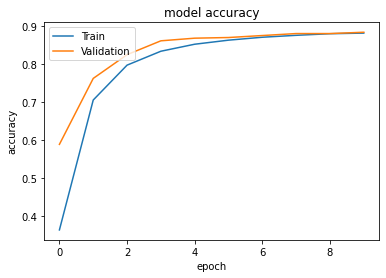

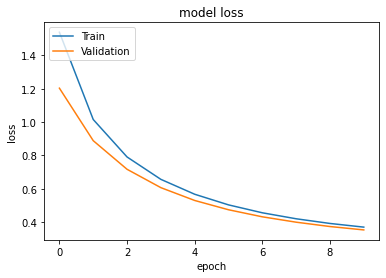

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_inception_newton"
model.save(export_path)

export_path

'savedModels/Intel_inception_newton'

In [82]:
export_path = "savedModels/Intel_inception_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

ValueError: Unknown optimizer: EHNewtonOptimizer

# --------------------------------------------------------------------

# ResNet Model

In [35]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (ResNet)

In [36]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [37]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
439/439 [==============================] - 29s 67ms/step - loss: 0.3205 - acc: 0.8853 - val_loss: 0.2399 - val_acc: 0.9062
Epoch 2/10
439/439 [==============================] - 25s 56ms/step - loss: 0.2006 - acc: 0.9262 - val_loss: 0.2206 - val_acc: 0.9132
Epoch 3/10
439/439 [==============================] - 25s 56ms/step - loss: 0.1732 - acc: 0.9363 - val_loss: 0.2092 - val_acc: 0.9115
Epoch 4/10
439/439 [==============================] - 25s 57ms/step - loss: 0.1545 - acc: 0.9446 - val_loss: 0.2150 - val_acc: 0.9201
Epoch 5/10
439/439 [==============================] - 25s 56ms/step - loss: 0.1409 - acc: 0.9498 - val_loss: 0.2356 - val_acc: 0.9010
Epoch 6/10
439/439 [==============================] - 25s 57ms/step - loss: 0.1303 - acc: 0.9528 - val_loss: 0.2122 - val_acc: 0.9167
Epoch 7/10
439/439 [==============================] - 25s 56ms/step - loss: 0.1208 - acc: 0.9554 - val_loss: 0.2172 - val_acc: 0.9201
Epoch 8/10
439/439 [==============================] - 25s 57ms

In [38]:
model.evaluate(test)

94/94 [==============================] - 5s 53ms/step - loss: 0.2228 - acc: 0.9180


[0.22281168755936495, 0.918]

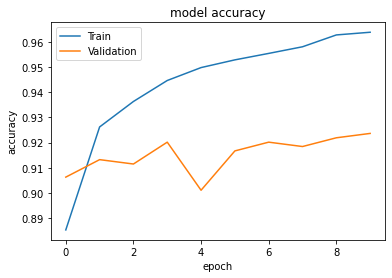

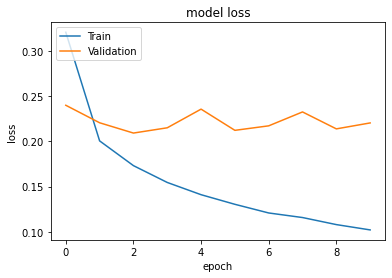

In [39]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Resnet_adam"
model.save(export_path)

export_path

'savedModels/Intel_Resnet_adam'

In [18]:
export_path = "savedModels/Intel_Resnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

94/94 [==============================] - 7s 73ms/step - loss: 1.1224 - acc: 0.9260


[1.1224465471632936, 0.926]

In [19]:
import urllib.request
from tensorflow.keras.preprocessing import image


# url = "https://image.freepik.com/free-photo/front-view-nice-street-city_23-2148798644.jpg"
url = "https://media.istockphoto.com/photos/snowcapped-k2-peak-picture-id1288385045?b=1&k=20&m=1288385045&s=170667a&w=0&h=3M3ZRl1bxOGxcvmYZ-TOtuJ3idm0psm4c7GFba1TA5g="
urllib.request.urlretrieve(url, 'image.jpg')

# Load image and resize (doesn't keep aspect ratio)
img1 = image.load_img('image.jpg', target_size=(224, 224))
# Turn to array of shape (224, 224, 3)
img = image.img_to_array(img1)
# Expand array into (1, 224, 224, 3)
img = np.expand_dims(img, 0)

img = img /255

[[0.00000024 0.00000004 0.45473185 0.5452652  0.         0.00000274]]
This image is a mountain


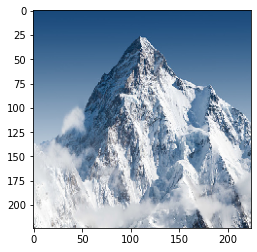

In [20]:
np.set_printoptions(suppress=True)
pred = reloaded.predict(img)
print (pred)

print ('This image is a', labels[np.argmax(pred)])
plt.imshow(img1)
plt.show()

# SGD Optimizer (ResNet)

In [10]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-06-06 21:08:59.629069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 21:08:59.630314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 21:08:59.630373: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 21:08:59.630406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 21:08:59.630434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 21:08:59.630463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-06 21:09:13.040945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 21:09:13.042309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 21:09:13.042387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 21:09:13.042427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 21:09:13.042460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 21:09:13.042492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-06-06 21:09:17.837494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 21:09:18.476072: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


439/439 [==============================] - 33s 76ms/step - loss: 0.3191 - acc: 0.8844 - val_loss: 0.2473 - val_acc: 0.9045
Epoch 2/10
439/439 [==============================] - 27s 62ms/step - loss: 0.2362 - acc: 0.9117 - val_loss: 0.2429 - val_acc: 0.9010
Epoch 3/10
439/439 [==============================] - 27s 61ms/step - loss: 0.2161 - acc: 0.9208 - val_loss: 0.2197 - val_acc: 0.9184
Epoch 4/10
439/439 [==============================] - 27s 62ms/step - loss: 0.2058 - acc: 0.9250 - val_loss: 0.2242 - val_acc: 0.9167
Epoch 5/10
439/439 [==============================] - 27s 62ms/step - loss: 0.1978 - acc: 0.9278 - val_loss: 0.2179 - val_acc: 0.9184
Epoch 6/10
439/439 [==============================] - 27s 62ms/step - loss: 0.1908 - acc: 0.9310 - val_loss: 0.2139 - val_acc: 0.9184
Epoch 7/10
439/439 [==============================] - 28s 64ms/step - loss: 0.1834 - acc: 0.9337 - val_loss: 0.2390 - val_acc: 0.9062
Epoch 8/10
439/439 [==============================] - 28s 64ms/step - los

In [12]:
model.evaluate(test)

94/94 [==============================] - 8s 90ms/step - loss: 0.2196 - acc: 0.9170


[0.2196206596699801, 0.917]

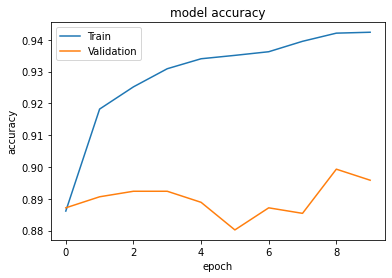

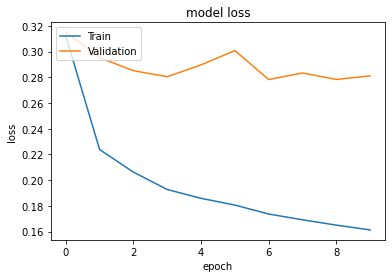

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Resnet_Sgd"
model.save(export_path)

export_path

'savedModels/Intel_Resnet_Sgd'

In [15]:
export_path = "savedModels/Intel_Resnet_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94/94 [==============================] - 14s 144ms/step - loss: 0.2201 - acc: 0.9170


[0.22010378501913014, 0.917]

# 

# Newton Optimizer (ResNet)

In [84]:
import newton_cg as es

In [85]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [86]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
439/439 [==============================] - 41s 94ms/step - loss: 1.4731 - acc: 0.3786 - val_loss: 1.1226 - val_acc: 0.6094
Epoch 2/10
439/439 [==============================] - 32s 72ms/step - loss: 0.9472 - acc: 0.7024 - val_loss: 0.8119 - val_acc: 0.7535
Epoch 3/10
439/439 [==============================] - 32s 72ms/step - loss: 0.7229 - acc: 0.8024 - val_loss: 0.6427 - val_acc: 0.8194
Epoch 4/10
439/439 [==============================] - 32s 72ms/step - loss: 0.5927 - acc: 0.8380 - val_loss: 0.5392 - val_acc: 0.8507
Epoch 5/10
439/439 [==============================] - 32s 73ms/step - loss: 0.5069 - acc: 0.8568 - val_loss: 0.4674 - val_acc: 0.8628
Epoch 6/10
439/439 [==============================] - 32s 74ms/step - loss: 0.4474 - acc: 0.8687 - val_loss: 0.4163 - val_acc: 0.8698
Epoch 7/10
439/439 [====================

In [87]:
model.evaluate(test)

94/94 [==============================] - 6s 60ms/step - loss: 0.3196 - acc: 0.8963


[0.31961870304447537, 0.89633334]

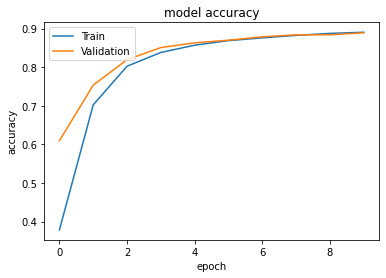

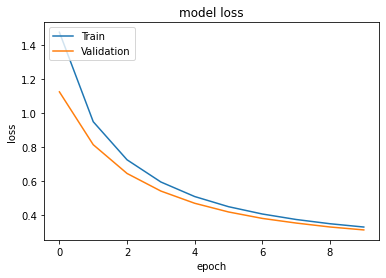

In [88]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [89]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Resnet_newton"
model.save(export_path)

export_path

'savedModels/Intel_Resnet_newton'

In [ ]:
export_path = "savedModels/Intel_Resnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# -----------------------------------------------------------------

# NasNet Model

In [101]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (NasNet)

In [11]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-06-06 18:45:40.428341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:45:40.429583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 18:45:40.429643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 18:45:40.429677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 18:45:40.429707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 18:45:40.429735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1056)              4269716   
_________________________________________________________________
dense (Dense)                (None, 6)                 6342      
Total params: 4,276,058
Trainable params: 6,342
Non-trainable params: 4,269,716
_________________________________________________________________


In [12]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-06 18:46:46.518255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 18:46:46.519660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-06 18:46:46.519784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-06 18:46:46.519850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 18:46:46.519913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-06 18:46:46.519974: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-06-06 18:47:09.515675: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-06 18:47:12.537025: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


439/439 [==============================] - 67s 153ms/step - loss: 0.3831 - acc: 0.8621 - val_loss: 0.2599 - val_acc: 0.8993
Epoch 2/10
439/439 [==============================] - 35s 79ms/step - loss: 0.2508 - acc: 0.9067 - val_loss: 0.2432 - val_acc: 0.9167
Epoch 3/10
439/439 [==============================] - 37s 84ms/step - loss: 0.2299 - acc: 0.9131 - val_loss: 0.2400 - val_acc: 0.9149
Epoch 4/10
439/439 [==============================] - 35s 79ms/step - loss: 0.2160 - acc: 0.9177 - val_loss: 0.2232 - val_acc: 0.9236
Epoch 5/10
439/439 [==============================] - 36s 81ms/step - loss: 0.2051 - acc: 0.9233 - val_loss: 0.2303 - val_acc: 0.9201
Epoch 6/10
439/439 [==============================] - 35s 80ms/step - loss: 0.1977 - acc: 0.9272 - val_loss: 0.2279 - val_acc: 0.9167
Epoch 7/10
439/439 [==============================] - 35s 79ms/step - loss: 0.1911 - acc: 0.9267 - val_loss: 0.2285 - val_acc: 0.9219
Epoch 8/10
439/439 [==============================] - 35s 81ms/step - lo

In [13]:
model.evaluate(test)

94/94 [==============================] - 8s 82ms/step - loss: 0.2337 - acc: 0.9150


[0.23374511325295935, 0.915]

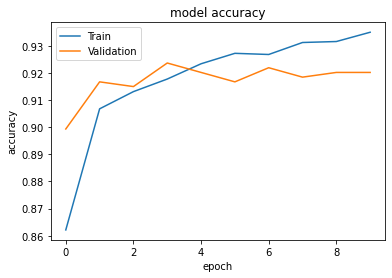

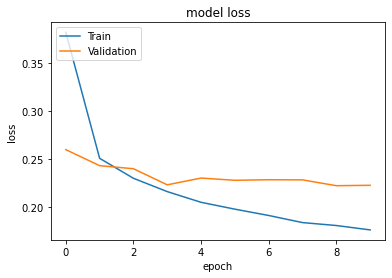

In [14]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Nasnet_adam"
model.save(export_path)

export_path

'savedModels/Intel_Nasnet_adam'

In [16]:
export_path = "savedModels/Intel_Nasnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94/94 [==============================] - 24s 255ms/step - loss: 0.2336 - acc: 0.9150


[0.2336150525494459, 0.915]

# SGD Optimizer (NasNet)

In [12]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1056)              4269716   
_________________________________________________________________
dense (Dense)                (None, 6)                 6342      
Total params: 4,276,058
Trainable params: 6,342
Non-trainable params: 4,269,716
_________________________________________________________________


In [13]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
439/439 [==============================] - 83s 189ms/step - loss: 0.4984 - acc: 0.8398 - val_loss: 0.3513 - val_acc: 0.8715
Epoch 2/10
439/439 [==============================] - 31s 71ms/step - loss: 0.3149 - acc: 0.8849 - val_loss: 0.3028 - val_acc: 0.8958
Epoch 3/10
439/439 [==============================] - 31s 70ms/step - loss: 0.2887 - acc: 0.8950 - val_loss: 0.2844 - val_acc: 0.9010
Epoch 4/10
439/439 [==============================] - 30s 69ms/step - loss: 0.2745 - acc: 0.8997 - val_loss: 0.2747 - val_acc: 0.9028
Epoch 5/10
439/439 [==============================] - 30s 68ms/step - loss: 0.2646 - acc: 0.9038 - val_loss: 0.2671 - val_acc: 0.9028
Epoch 6/10
439/439 [==============================] - 30s 69ms/step - loss: 0.2570 - acc: 0.9060 - val_loss: 0.2610 - val_acc: 0.9045
Epoch 7/10
439/439 [==============================] - 30s 69ms/step - loss: 0.2512 - acc: 0.9084 - val_loss: 0.2572 - val_acc: 0.8976
Epoch 8/10
439/439 [==============================] - 30s 69m

In [14]:
model.evaluate(test)

94/94 [==============================] - 6s 63ms/step - loss: 0.2474 - acc: 0.9060


[0.24743151886666076, 0.906]

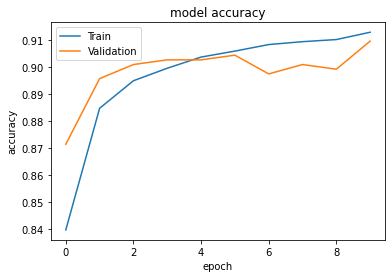

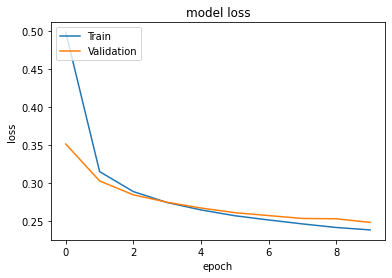

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Nasnet_sgd"
model.save(export_path)

export_path

'savedModels/Intel_Nasnet_sgd'

In [17]:
export_path = "savedModels/Intel_Nasnet_sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

94/94 [==============================] - 20s 212ms/step - loss: 0.2477 - acc: 0.9060


[0.24773935862678162, 0.906]

# Newton Optimizer (NasNet)

In [102]:
import newton_cg as es

In [103]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1056)              4269716   
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 6342      
Total params: 4,276,058
Trainable params: 6,342
Non-trainable params: 4,269,716
_________________________________________________________________


In [104]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
439/439 [==============================] - 54s 123ms/step - loss: 1.5093 - acc: 0.4164 - val_loss: 1.1652 - val_acc: 0.6997
Epoch 2/10
439/439 [==============================] - 30s 69ms/step - loss: 0.9994 - acc: 0.7769 - val_loss: 0.8619 - val_acc: 0.8229
Epoch 3/10
439/439 [==============================] - 30s 69ms/step - loss: 0.7676 - acc: 0.8405 - val_loss: 0.6946 - val_acc: 0.8438
Epoch 4/10
439/439 [==============================] - 30s 69ms/step - loss: 0.6301 - acc: 0.8598 - val_loss: 0.5885 - val_acc: 0.8507
Epoch 5/10
439/439 [==============================] - 31s 70ms/step - loss: 0.5393 - acc: 0.8690 - val_loss: 0.5154 - val_acc: 0.8628
Epoch 6/10
439/439 [==============================] - 31s 70ms/step - loss: 0.4756 - acc: 0.8740 - val_loss: 0.4633 - val_acc: 0.8698
Epoch 7/10
439/439 [===================

In [105]:
model.evaluate(test)

94/94 [==============================] - 6s 59ms/step - loss: 0.3479 - acc: 0.8837


[0.3478652796846755, 0.8836667]

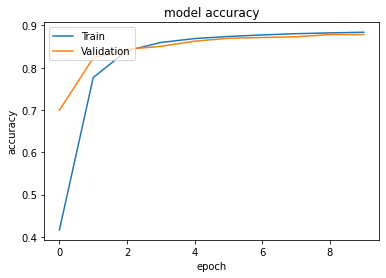

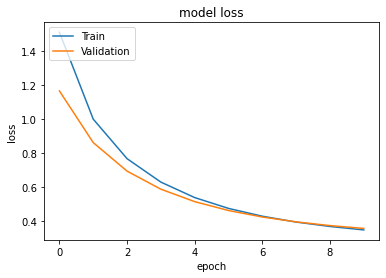

In [106]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [107]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_Nasnet_newton"
model.save(export_path)

export_path

'savedModels/Intel_Nasnet_newton'

In [ ]:
export_path = "savedModels/Intel_Nasnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# ----------------------------------------------------------------------------

# Inception_ResNet Model

In [122]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (Inception_ResNet)

In [123]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [124]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
439/439 [==============================] - 76s 172ms/step - loss: 0.3270 - acc: 0.8807 - val_loss: 0.2452 - val_acc: 0.8958
Epoch 2/10
439/439 [==============================] - 51s 117ms/step - loss: 0.2355 - acc: 0.9156 - val_loss: 0.2590 - val_acc: 0.9062
Epoch 3/10
439/439 [==============================] - 51s 117ms/step - loss: 0.2142 - acc: 0.9206 - val_loss: 0.2228 - val_acc: 0.9097
Epoch 4/10
439/439 [==============================] - 52s 118ms/step - loss: 0.2089 - acc: 0.9233 - val_loss: 0.2081 - val_acc: 0.9149
Epoch 5/10
439/439 [==============================] - 52s 118ms/step - loss: 0.1953 - acc: 0.9282 - val_loss: 0.2384 - val_acc: 0.9045
Epoch 6/10
439/439 [==============================] - 52s 118ms/step - loss: 0.1889 - acc: 0.9290 - val_loss: 0.2067 - val_acc: 0.9132
Epoch 7/10
439/439 [==============================] - 52s 118ms/step - loss: 0.1824 - acc: 0.9312 - val_loss: 0.2057 - val_acc: 0.9201
Epoch 8/10
439/439 [==============================] - 5

In [125]:
model.evaluate(test)

94/94 [==============================] - 10s 106ms/step - loss: 0.2207 - acc: 0.9230


[0.22069641598995696, 0.923]

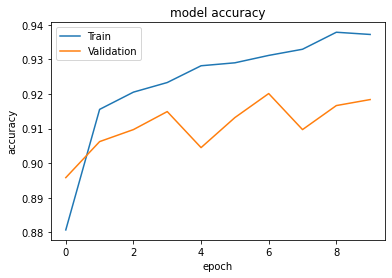

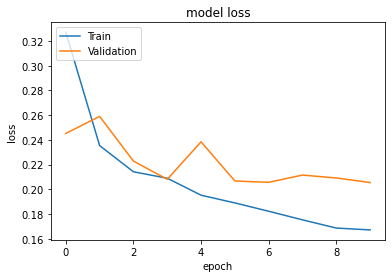

In [126]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [127]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_incResnet_adam"
model.save(export_path)

export_path

'savedModels/Intel_incResnet_adam'

In [128]:
export_path = "savedModels/Intel_incResnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

94/94 [==============================] - 21s 223ms/step - loss: 0.2205 - acc: 0.9230


[0.22045504028334262, 0.923]

# SGD Optimizer (Inception_ResNet)

In [23]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [24]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
439/439 [==============================] - 90s 204ms/step - loss: 0.3769 - acc: 0.8636 - val_loss: 0.2574 - val_acc: 0.8993
Epoch 2/10
439/439 [==============================] - 53s 120ms/step - loss: 0.2637 - acc: 0.9048 - val_loss: 0.2310 - val_acc: 0.9149
Epoch 3/10
439/439 [==============================] - 53s 121ms/step - loss: 0.2454 - acc: 0.9119 - val_loss: 0.2231 - val_acc: 0.9149
Epoch 4/10
439/439 [==============================] - 53s 120ms/step - loss: 0.2341 - acc: 0.9158 - val_loss: 0.2098 - val_acc: 0.9236
Epoch 5/10
439/439 [==============================] - 53s 121ms/step - loss: 0.2281 - acc: 0.9169 - val_loss: 0.2059 - val_acc: 0.9253
Epoch 6/10
439/439 [==============================] - 53s 121ms/step - loss: 0.2208 - acc: 0.9206 - val_loss: 0.2037 - val_acc: 0.9340
Epoch 7/10
439/439 [==============================] - 53s 122ms/step - loss: 0.2161 - acc: 0.9208 - val_loss: 0.1970 - val_acc: 0.9306
Epoch 8/10
439/439 [==============================] - 5

In [25]:
model.evaluate(test)

94/94 [==============================] - 10s 112ms/step - loss: 0.2214 - acc: 0.9167


[0.22140892285932887, 0.9166667]

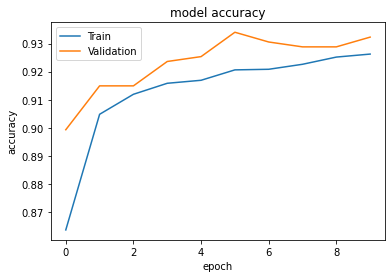

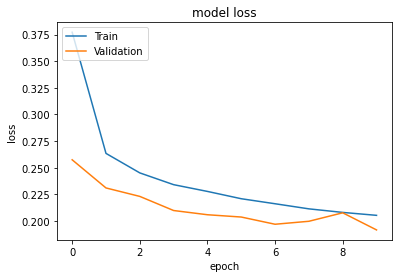

In [26]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_incResnet_sgd"
model.save(export_path)

export_path

'savedModels/Intel_incResnet_sgd'

In [ ]:
export_path = "savedModels/Intel_incResnet_sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# Newton Optimizer (Inception_ResNet)

In [129]:
import newton_cg as es

In [130]:
num_of_classes = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [131]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
439/439 [==============================] - 86s 196ms/step - loss: 1.3702 - acc: 0.4545 - val_loss: 1.0748 - val_acc: 0.6962
Epoch 2/10
439/439 [==============================] - 58s 132ms/step - loss: 0.9000 - acc: 0.7878 - val_loss: 0.7812 - val_acc: 0.8368
Epoch 3/10
439/439 [==============================] - 59s 135ms/step - loss: 0.6861 - acc: 0.8500 - val_loss: 0.6205 - val_acc: 0.8715
Epoch 4/10
439/439 [==============================] - 59s 135ms/step - loss: 0.5599 - acc: 0.8693 - val_loss: 0.5204 - val_acc: 0.8889
Epoch 5/10
439/439 [==============================] - 59s 134ms/step - loss: 0.4781 - acc: 0.8799 - val_loss: 0.4533 - val_acc: 0.8958
Epoch 6/10
439/439 [==============================] - 59s 134ms/step - loss: 0.4221 - acc: 0.8869 - val_loss: 0.4062 - val_acc: 0.8993
Epoch 7/10
439/439 [==============

In [132]:
model.evaluate(test)

94/94 [==============================] - 10s 107ms/step - loss: 0.3127 - acc: 0.8947


[0.31269585127209093, 0.8946667]

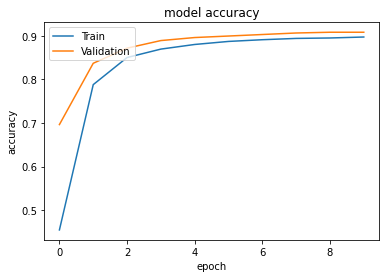

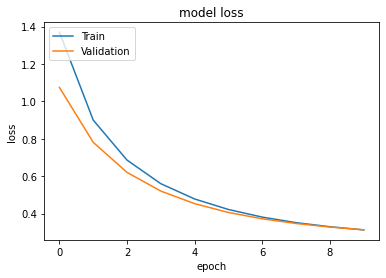

In [133]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [134]:
import time
import datetime

t = time.time()

export_path = "savedModels/Intel_incResnet_newton"
model.save(export_path)

export_path

'savedModels/Intel_incResnet_newton'

In [ ]:
export_path = "savedModels/Intel_incResnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)